# `OLA DRIVER  CHURN PROJECT`

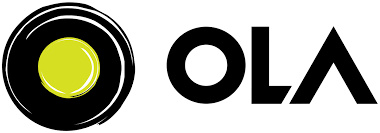

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

In [ ]:
ola = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv')

In [ ]:
ola.head()

# `EXPLORATORY DATA ANALYSIS`

In [ ]:
print('Rows in the ola dataset: ',ola.shape[0])
print('Columns in the ola dataset: ',ola.shape[1])

In [ ]:
ola.info()

`Column Profiling:`
• MMMM-YY : Reporting Date (Monthly) (date-time)

• Age : Age of the employee (numerical)

• Gender : Gender of the employee – Male : 0, Female: 1 (categorical)

• City : City Code of the employee (categorical)

• Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate (categorical)

• Income : Monthly average Income of the employee (numerical)

• Date Of Joining : Joining date for the employee (date-time)

• LastWorkingDate : Last date of working for the employee - Target Feature (date-time, but
will be converted to categorical)

• Joining Designation : Designation of the employee at the time of joining (categorical, ordinal)

• Grade : Grade of the employee at the time of reporting (categorical, ordinal)

• Total Business Value : The total business value acquired by the employee in a month (negative
business indicates cancellation/refund or car EMI adjustments) (numerical)

• Quarterly Rating : Quarterly rating of the employee: 1,2,3,4,5 (categorical, ordinal - higher
is better)


In [ ]:
ola.describe()

In [ ]:
ola.describe(include='object')

In [ ]:
# since  unnamed and driver_id columns have the highest correlation and they r the same
# here, dropping unnamed column

In [ ]:
ola.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [ ]:
ola.nunique()

In [ ]:
ola.isna().sum()

In [ ]:
ola.head(3)

# `DATA PROCESSING AND FEATURE ENGINEERING`

In [ ]:
ola1 = ola.copy(deep=True)

In [ ]:
# # Target variable creation: Create a column called target which tells whether the driver has left the company- 
# # driver whose last working day is present will have the value 1

first =  (ola1.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isna()).reset_index()
first['LastWorkingDate'].replace({True:1,False:0},inplace=True)
first.rename(columns={'LastWorkingDate':'target'},inplace=True)
first.head()

In [ ]:
# Create a column which tells whether the quarterly rating has increased for that driver - 
# for those whose quarterly rating has increased we assign the value 1
QR1 =  (ola1.groupby('Driver_ID').agg({'Quarterly Rating':'first'})['Quarterly Rating']).reset_index()
QR2 = (ola1.groupby('Driver_ID').agg({'Quarterly Rating':'last'})['Quarterly Rating']).reset_index()

In [ ]:
QR1.shape,QR2.shape

In [ ]:
QR1.isna().sum(),QR2.isna().sum()

In [ ]:
first = first.merge(QR1,on='Driver_ID')
first = first.merge(QR2,on='Driver_ID')

In [ ]:
first.head()

In [ ]:
first['Promotion'] = np.where(first['Quarterly Rating_x'] == first['Quarterly Rating_y'], 0,1)

In [ ]:
# Create a column which tells whether the monthly income has increased for that driver - 
# for those whose monthly income has increased we assign the value 1
incm1 =  (ola1.groupby('Driver_ID').agg({'Income':'first'})['Income']).reset_index()
incm2 = (ola1.groupby('Driver_ID').agg({'Income':'last'})['Income']).reset_index()

In [ ]:
incm1.shape,incm2.shape

In [ ]:
incm1.isna().sum(),incm2.isna().sum()

In [ ]:
first = first.merge(incm1,on='Driver_ID')
first = first.merge(incm2,on='Driver_ID')

In [ ]:
first.head()

In [ ]:
first['Raise'] = np.where(first['Income_x'] == first['Income_y'], 0,1)

In [ ]:
first.head()

In [ ]:
first.tail()

In [ ]:
first = first[['Driver_ID','target','Raise','Promotion']]

In [ ]:
first.head()

In [ ]:
functions = {'MMM-YY':'count',
             'Driver_ID':'first',
             'Age':'max',
             'Gender':'last',
            'City':'last',
             'Education_Level':'last',
             'Dateofjoining':'first',
            'LastWorkingDate':'last',
             'Grade':'last',
             'Total Business Value':'sum',
            'Income':'sum',
             'Dateofjoining':'first',
             'LastWorkingDate':'last',
            'Joining Designation':'last',
             'Grade':'last',
             'Quarterly Rating':'first'}
ola1 = ola1.groupby([ola1['Driver_ID']]).aggregate(functions)
ola1['month'] = pd.to_datetime(ola['Dateofjoining']).dt.month
ola1['year'] = pd.DatetimeIndex(ola1['Dateofjoining']).year
ola1.rename(columns={'MMM-YY':'Reportings'},inplace=True)

In [ ]:
ola1.reset_index(drop=True, inplace=True)
ola1 = ola1.merge(first,on='Driver_ID')
ola1.head()

In [ ]:
import regex
ola1['Age'] = ola1['Age'].astype('int64')
ola1['Cities'] =ola1['City'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

In [ ]:
ola1.info()

In [ ]:
ola1.drop(columns=['Dateofjoining','LastWorkingDate','City'],axis=1,inplace=True)
ola1['Gender'].replace({'M':0,'F':1},inplace=True)
ola1['Gender'] = ola1['Gender'].astype('int64')

In [ ]:
ola1.head()

In [ ]:
sum(ola1.isna().sum())

In [ ]:
ola1.describe().T

# `DATA VISUALIZATION`

## Univariate 

In [ ]:
# figure1
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
sns.countplot(y=ola1.month,palette='viridis')
plt.title('Months representing how many drivers joined OLA each month',fontname='Franklin Gothic Medium', fontsize=15)


ax = fig.add_subplot(1,2,2)
sns.countplot(y=ola1.year,palette='viridis')
plt.title('Years representing how many drivers joined OLA each year',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

### Observations:

    - July received the maximum number of drivers in 8 years.
    - February and March receives the least number of Drivers joining OLA.
    - Joining of Drivers receives a boost of about 500% after 2017.
    

In [ ]:
# figure2
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(121)
sns.countplot(x=ola1.Age,palette='viridis',width=0.8)
plt.title('Age of Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.xticks(rotation=90)

ax = fig.add_subplot(122)
a = pd.cut(ola1.Age,bins=[11,21,31,41,51,61],labels=['11,21','21-31','31-41','41-51','51-61'])
sns.countplot(x=a,palette='viridis')
plt.title('Groupwise Age count of Drivers',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()


In [ ]:
# figure3
fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(121)
sns.countplot(x=ola1.Cities,palette='viridis',width=0.6)
plt.title('Cities alloted to Drivers',fontname='Franklin Gothic Medium', fontsize=13)
plt.xticks(rotation=90)

ax = fig.add_subplot(122)
sns.countplot(x=ola1.Reportings,palette='viridis',width=0.6)
plt.title('Number of Reportings of Drivers',fontname='Franklin Gothic Medium', fontsize=13)
          
# ax = fig.add_subplot(133)
# sns.countplot(x=ola1.Education_Level,palette='viridis')
# plt.title('Educational Level of Drivers',fontname='Franklin Gothic Medium', fontsize=13)
sns.despine()
plt.show()

In [ ]:
# figure4
plt.figure(figsize=(20,13))
plt.subplot(4,2,1)
sns.countplot(x=ola1.Grade,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,2)
sns.countplot(x=ola1['Joining Designation'],palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,3)
sns.countplot(x=ola1.Education_Level,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,4)
sns.countplot(x=ola1['Quarterly Rating'],palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,5)
sns.countplot(x=ola1.target,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,6)
sns.countplot(x=ola1.Raise,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,7)
sns.countplot(x=ola1.Promotion,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(4,2,8)
sns.countplot(x=ola1.Gender,palette='viridis')
# plt.title('Grade given to different Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.show()

### Observations:

    - Between 21 years(min age) to 58(max age) years of age, maximum number of drivers are 32 years o
    meanwhile the age group between 31-41 years of age receives the maximum number of drivers.
    - 58.9% of the Drivers are male.
    - City C20 has been used by the most of the drivers.
    - There are 3 Education levels and all of them alomst have the equal distribution of Drivers.
    - Grade 2 has been received by most of the Drivers and then the count of grade keeps on falling.

In [ ]:
a =ola1[['Age','Income','Total Business Value']]
for i in a:
    plt.figure(figsize=(12,2))
    plt.subplot(121)
    sns.distplot(x=ola1[i],color='teal')
    plt.title('')
    plt.xticks(rotation=90)

    plt.subplot(122)
    sns.boxplot(x=ola1[i],color='mediumvioletred')
    plt.title('')
    sns.despine()
    plt.show()

## Bivariate  and multivariate

In [ ]:
corr = ola1.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr,annot=True,cmap='Greens')
plt.show()

In [ ]:
fig = plt.figure(figsize=(22,5))
ax = fig.add_subplot(1,3,1)
grouped_months = ola1.groupby(['month'])['Reportings'].count().reset_index()
sns.barplot(data=grouped_months,x='month',y='Reportings',palette='viridis')
plt.title('Reportings of Driver every month',fontname='Franklin Gothic Medium', fontsize=15)

ax = fig.add_subplot(1,3,2)
grouped_years = ola1.groupby(['year'])['Reportings'].count().reset_index()
sns.barplot(x='year', y='Reportings', data=grouped_years,palette='viridis')
plt.title('Reportings of Driver every year',fontname='Franklin Gothic Medium', fontsize=15)

ax = fig.add_subplot(1,3,3)
grouped_gender = ola1.groupby('Gender')['Reportings'].sum().reset_index()
grouped_gender['Reportings'] =(grouped_gender['Reportings']/sum(ola1.Reportings)*100).round(2)
sns.barplot(x=grouped_gender['Gender'],y= grouped_gender['Reportings'],palette='viridis')
plt.title('Reportings of Driver by Gender in percentage',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
sns.despine()
plt.show()

In [ ]:
grouped_gender

In [ ]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
sns.lineplot(x=ola1.Age,y=ola1.Grade,hue=ola1.target,palette='viridis')
plt.title('Age of Drivers in context with Grades and Target variable',fontname='Franklin Gothic Medium', fontsize=15)

ax = fig.add_subplot(1,2,2)
sns.barplot(data=ola1, x="Joining Designation", y="Grade",palette='viridis',hue='target')
plt.title('Joining Designation with Grade',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

In [ ]:
# figure7
plt.figure(figsize=(25,7))
plt.subplot(1,4,1)
sns.violinplot(y=ola1.Age,x=ola1['Joining Designation'],palette='viridis')
plt.title('Income of Drivers according to Designation',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(1,4,2)
sns.violinplot(x=ola1.Grade,y=ola1.Income,palette='viridis')
plt.title('Income of Drivers according to Grade',fontname='Franklin Gothic Medium', fontsize=15)
plt.xticks(rotation=90)
plt.subplot(1,4,3)
sns.violinplot(x=ola1.Education_Level,y=ola1.Income,palette='viridis')
plt.title('Income of Drivers according to Their Education Level',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(1,4,4)
sns.violinplot(x=ola1['Grade'],y=ola1["Quarterly Rating"],palette='viridis')
plt.title('Distribution of Quarterly Rating in context with Grade')
sns.despine()
sns.despine()
plt.show()

In [ ]:
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
sns.scatterplot(x=ola1.Age,y=ola1.Income,color='olive')
plt.title('Scatterplot of Income and Age of the Drivers',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(1,2,2)
sns.scatterplot(x=ola1.Age,y=ola1['Total Business Value'],color='teal')
plt.title('Scatterplot of Total Business Value and Age',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

In [ ]:
grouped_gender = ola1.groupby('Gender')['Income'].sum().reset_index()
grouped_education = ola1.groupby('Education_Level')['Income'].sum().reset_index()
grouped_grade = ola1.groupby('Grade')['Income'].sum().reset_index()
grouped_desig = ola1.groupby('Joining Designation')['Income'].sum().reset_index()
grouped_QR = ola1.groupby('Quarterly Rating')['Income'].sum().reset_index()
grouped_target = ola1.groupby('target')['Income'].sum().reset_index()
grouped_raise = ola1.groupby('Raise')['Income'].sum().reset_index()
grouped_promote = ola1.groupby('Promotion')['Income'].sum().reset_index()

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(3,3,1)
plt.pie(grouped_gender['Income'], labels=grouped_gender['Gender'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Gender')
plt.subplot(3,3,2)
plt.pie(grouped_education['Income'], labels=grouped_education['Education_Level'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Education Level')
plt.subplot(3,3,3)
plt.pie(grouped_grade['Income'], labels=grouped_grade['Grade'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Grade')
plt.subplot(3,3,4)
plt.pie(grouped_desig['Income'], labels=grouped_desig['Joining Designation'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Joining Designation')
plt.subplot(3,3,5)
plt.pie(grouped_QR['Income'], labels=grouped_QR['Quarterly Rating'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Quarterly Rating')
plt.subplot(3,3,6)
plt.pie(grouped_target['Income'], labels=grouped_target['target'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Target variable')
plt.subplot(3,3,7)
plt.pie(grouped_raise['Income'], labels=grouped_raise['Raise'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Raise given')
plt.subplot(3,3,8)
plt.pie(grouped_promote['Income'], labels=grouped_promote['Promotion'], autopct='%1.1f%%', startangle=90,colors=sns.color_palette('flare'))
hole = plt.Circle((0, 0), 0.5, facecolor='white')
plt.gcf().gca().add_artist(hole)
plt.title('Income with respect to Promotion Given')
sns.despine()
plt.show()

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,1,1)
sns.countplot(x=ola1['Reportings'],hue=ola1.target,palette='viridis')
plt.title('Reporting report by Drivers according to Target Variable',fontname='Franklin Gothic Medium', fontsize=15)
plt.subplot(2,1,2)
grouped_rating = ola1.groupby('Quarterly Rating')['Reportings'].count().reset_index()
sns.barplot(data = grouped_rating,y='Reportings',x='Quarterly Rating',palette='viridis')
plt.title('Reporting report by Drivers according to Quarterly Ratings Given',fontname='Franklin Gothic Medium', fontsize=15)
sns.despine()
plt.show()

In [ ]:
plt.figure(figsize=(22,5))
plt.subplot(1,3,1)
sns.scatterplot(x=ola1['Total Business Value'],y=ola1.Income,hue=ola1.Raise)
plt.subplot(1,3,2)
sns.scatterplot(x=ola1['Total Business Value'],y=ola1.Income,hue=ola1.Reportings)
plt.subplot(1,3,3)
sns.scatterplot(x=ola1['Total Business Value'],y=ola1.Income,hue=ola1.Promotion)
sns.despine()
plt.show()

### `Observation:-`

- So we see that there are 57% male employees and 43% female employees.
- The percentages of employees with different education levels are almost same for level 1 & 2.
- 97.3% of the employees who did not get a raise. 
- Almost 43% of the employees joined at lowest designation (1). 34% joined at level 2, 20% at level 3 and below 2% joined at higher levels.
- Majority (35%) of the employees currently are at designation level 2, followed by designation level 1 (31%) and 3 (26%). Less than 5% of the employees are currently in higher designations.
- Only 54.6% of the employees received a promotion, while 45.4% did not. However, only 2.6% received a raise in income. 
- Number of employees has been increase with increase in year as well as number of reportings.
- The majority of the employees seem to be associated with city C20.
- Scatter plot of Income shows that Income increases with increase in age but after 45-50, we see a subtle decline.
- Scatter plot of Total Business Value shows an increase with increase in Age yet we notice a decline after 45.
- Income decreses with increase in Destination as about 4% of the employees hold higher designations.
- The median of the Income for employees having higher Grades is greater.
- Distribution of Income for enployes at different Education level is about a change of 3-5% with level 0.
- Joining Designation Increases with increase in Grade.
- Max reporting days is 24 days.
- About 55% of the reportings of the employees has got Quarlerly Rating 1.
- Number of reportings increases with increase in Income as well as Total Business Value.

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.kdeplot(x=ola1.Income,hue=ola1['target'],palette='magma')
plt.subplot(1,2,2)
sns.kdeplot(x=ola1.Income,hue=ola1['Promotion'],palette='magma')
plt.show()

# `OUTLIER TREATMENT`

In [ ]:
ola1.describe().T

In [ ]:
len(ola1[ola1['Total Business Value'] < 1])

_As we can notice Total Business Value column has some values in negative._

_We consider them as outlier which will affect the results of the our machine learning model._

_Considering the parts of datasets that has Total Business Value > 1._

_There are exactly 729 Driver having Total Business Value that less than 1._

In [ ]:
ola1= ola1[ola1['Total Business Value'] > 1]

In [ ]:
a =ola1[['Age','Income','Total Business Value']]
for i in a:
    plt.figure(figsize=(12,3))
    plt.subplot(121)
    sns.distplot(x=ola1[i],color='red')
    plt.xticks(rotation=90)
#     plt.figure(figsize=(9,5))
    plt.subplot(122)
    sns.boxplot(x=ola1[i],color='mediumvioletred')
    sns.despine()
    plt.show()

In [ ]:
corr = ola1.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr,annot=True,cmap='Greens')
plt.show()

In [ ]:
ola1.describe().T

# `ENSEMBLE LEARNING:- `
### `Data Prepration:-`

The Trade-Off In general while choosing a model, we might choose to look at precision and recall scores and choose while keeping the follwing trade-off on mind : - 

If we prioritize precision, we are going to reduce our false positives. This may be useful if our targeted retention strategies
prove to be expensive. We don’t want to spend unnecessarily on somebody who is not even going to
leave in the first place. Also, it might lead to uncomfortable situation for the employee themselves
if they are put in a situation where it is assumed that they are going to be let go/ going to leave.
• If we prioritize recall, we are going to reduce our false negatives. This is useful since usually
the cost of hiring a new person is higher than retaining n experienced person. So, by reducing
false negatives, we would be able to better identify those who are actually going to leave and
try to retain them by appropriate measures (competitve remuneration, engagement program, etc).


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
X = ola1.drop('target',axis=1)
y = ola1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

In [ ]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, X, Y, title):
    train_sizes, train_scores, test_scores, _, _ = learning_curve(estimator,X,Y,return_times=True)
    fig, axes = plt.subplots(1, 1, figsize = (15, 5))
    axes.set_title(title)
    axes.plot
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # Plot learning curve
#     32
    axes.grid()
    axes.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
    )
    axes.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
    )
    axes.plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")
    plt.show()

In [ ]:
X.head()

In [ ]:
ss= StandardScaler()
ss.fit_transform(X_train)

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
valid1 = cross_val_score(LogisticRegression(),X,y,cv=5)
print('Logistic Regression:',valid1.round(2))
print('Mean:',valid1.mean())
valid2 = cross_val_score( DecisionTreeClassifier(),X,y,cv=5)
print('Decision Tree:',valid2.round(3))
print('Mean:',valid2.mean())
valid3 = cross_val_score(RandomForestClassifier(),X,y,cv=5)
print('RandomForestClassifier():',valid3.round(2))
print('Mean:',valid3.mean())
valid4 = cross_val_score(GradientBoostingClassifier(),X,y,cv=5)
print('GradientBoostingClassifier:',valid4.round(3))
print('Mean:',valid4.mean())
valid5 =cross_val_score(XGBClassifier(),X,y,cv=5)
print('XGBoostClassifier:',valid1.round(2))
print('Mean:',valid5.mean())

# `MACHINE LEARNING MODEL:-`
# `WITHOUT THE TREATMENT OF CLASS IMBALANCE`

### `Random Forest Classifier`

In [ ]:
# model = RandomForestClassifier()
# param_grid = { 
#     'n_estimators':list(range(10,20)),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

In [ ]:
# clf = GridSearchCV(model,param_grid,cv=10,scoring='recall')
# clf.fit(X_train,y_train)

In [ ]:
# clf.best_params_

In [ ]:
rf_clf1 = RandomForestClassifier(criterion='gini',max_depth=7,max_features='sqrt',n_estimators=10)
rf_clf1.fit(X_train,y_train)

In [ ]:
plot_learning_curve(rf_clf1, X_train, y_train, "Random ForestTrees")

In [ ]:
y_pred = rf_clf1.predict(X_test)
proba = rf_clf1.predict_proba(X_test)[:,1]
print("Train data accuracy:",rf_clf1.score(X_train, y_train))
print("Test data accuracy:",rf_clf1.score(X_test,y_test))
print('Accuracy of the model:', accuracy_score(y_test, y_pred))
print("ROC-AUC score test dataset: ", roc_auc_score(y_test, proba))
print('-'*70)
print(classification_report(y_test, y_pred))
print('-'*70)
cm1 = (confusion_matrix(y_test, y_pred))
print('Confusion Metrix')
print(confusion_matrix(y_test, y_pred))

In [ ]:
rf_clf_imp1 = rf_clf1.feature_importances_

### `XG Boosting Classifier`

In [ ]:
gbc1 = GradientBoostingClassifier()
gbc1.fit(X_train, y_train)
y_pred = gbc1.predict(X_test)
proba =gbc1.predict_proba(X_test)[:, 1]

In [ ]:
plot_learning_curve(gbc1, X_train, y_train, "Random ForestTrees")

In [ ]:
gbc_clf_imp1 = gbc1.feature_importances_

In [ ]:
print('Train Score : ', gbc1.score(X_train, y_train))
print('Test Score : ', gbc1.score(X_test, y_test))
print('Accuracy Score : ', accuracy_score(y_test, y_pred))
print("ROC-AUC score test dataset: ", roc_auc_score(y_test, proba))
print('-'*60)
print(classification_report(y_test, y_pred))
print('-'*60)
print('Confusion Matrix')
cm2 = (confusion_matrix(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('-'*60)

# `CLASS IMBALANCE TREATMENT`

In [ ]:
plt.figure(figsize=(15,4))
sns.countplot(x=y_train,palette='Set2')
plt.title('Class Imbalance in the Data')
plt.show()

In [ ]:
(y_train.value_counts()*100)/len(y_train)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smot = SMOTE(random_state=42)
X_train_smot,y_train_smot = smot.fit_resample(X_train,y_train.ravel())

In [ ]:
X_train_smot.shape,y_train_smot.shape

In [ ]:
X_test.shape,y_test.shape

In [ ]:
from collections import Counter
c = Counter(y_train_smot)
print(c)

### `Randome Forest Classifier`

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train_smot,y_train_smot)

In [ ]:
# param_grid = { 
#     'n_estimators':list(range(10,20)),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

In [ ]:
# clf = GridSearchCV(clf,param_grid,cv=10,scoring='recall')
# clf.fit(X_train_smot,y_train_smot)

In [ ]:
# clf.best_params_

In [ ]:
clf = RandomForestClassifier(criterion='gini',max_depth=8,
                           max_features='sqrt',n_estimators= 19)
clf.fit(X_train_smot,y_train_smot)

In [ ]:
plot_learning_curve(clf, X_train_smot, y_train_smot, "Random ForestTrees")

In [ ]:
y_pred = clf.predict(X_test)
print('-'*70)
print(classification_report(y_test, y_pred))
print('-'*70)
print('Confusion Metrix')
cm3 = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

In [ ]:
rf_clf_imp2= clf.feature_importances_

### `Gradient Boosting`

In [ ]:
gbc2 = GradientBoostingClassifier()
gbc2.fit(X_train_smot, y_train_smot)
y_pred1 = gbc2.predict(X_test)
gbc_clf_imp2 = gbc2.feature_importances_
print('-'*60)
print(classification_report(y_test, y_pred1))
print('-'*60)
cm4 = confusion_matrix(y_test, y_pred1)
print('Confusion Matrix')
print(cm4)
print('-'*60)

In [ ]:
plot_learning_curve(gbc2, X_train_smot, y_train_smot, "Gradient Boosting")

In [ ]:
data1 = pd.DataFrame({'Column_Name':X.columns,
                    'RandomForestClassifier':rf_clf_imp1,
                    'XGBClassifier':gbc_clf_imp1})

In [ ]:
data2 = pd.DataFrame({'Column_Name':X.columns,
                    'RandomForestClassifier':rf_clf_imp2,
                    'XGBClassifier':gbc_clf_imp2})

In [ ]:
data1

In [ ]:
data2

In [ ]:
data1.plot(kind="area", figsize = (15,2),color=['teal','maroon'])

data2.plot(kind="area", figsize = (15,2),color=['teal','black'])

plt.show()

In [ ]:
# calculating precision, reall and f1_score for every 
tp1,fp1,fn1,tn1 =cm1[0][0],cm1[0][1],cm1[1][0],cm1[1][1]
tp2,fp2,fn2,tn2 =cm2[0][0],cm2[0][1],cm2[1][0],cm2[1][1]
tp3,fp3,fn3,tn3 =cm3[0][0],cm3[0][1],cm3[1][0],cm3[1][1]
tp4,fp4,fn4,tn4 =cm4[0][0],cm4[0][1],cm4[1][0],cm4[1][1]
precision1 = tp1/(tp1+fp1)
recall1 = tp1/(tp1+fn1)
precision2 = tp2/(tp2+fp2)
recall2 = tp2/(tp2+fn2)
precision3 = tp3/(tp3+fp3)
recall3 = tp3/(tp3+fn3)
precision4 = tp4/(tp4+fp4)
recall4 = tp4/(tp4+fn4)
f1_1 = (2*precision1*recall1)/(precision1+recall1)
f1_2 = (2*precision2*recall2)/(precision2+recall2)
f1_3 = (2*precision3*recall3)/(precision3+recall3)
f1_4 =(2*precision4*recall4)/(precision4+recall4)

In [ ]:
df = pd.DataFrame({'Model':['RandomForest','GradientBoosting','RandomForest','GradientBoosting'],
                  'Class':['imbalanced','imbalanced','balanced','balanced'],
                  'True_pos':[tp1,tp2,tp3,tp4],
                  'Fal_pos':[fp1,fp2,fp3,fp4],
                  'Fal_neg':[fn1,fn2,fn3,fn4],
                  'True_neg':[tn1,tn2,tn3,tn4],
                  'F1_score%':[f1_1*100,f1_2*100,f1_3*100,f1_4*100],
                  'Precision%':[precision1*100,precision2*100,precision3*100,precision4*100],
                  'Recall%':[recall1*100,recall2*100,recall3*100,recall4*100]})

In [ ]:
df

In [ ]:
# df.plot(kind="bar", figsize = (15,5),colormap='cividis')
# plt.title('Representation of True Positives, True Negatives,False Positives, False Negatives and F1_score of all the Models')
# plt.show()
# ,color=['red','blue','olive','teal','maroon']

In [ ]:
plt.figure(figsize=(22,4))
plt.subplot(2,3,1)
sns.barplot(x=df.Class,y=df.True_pos,palette='viridis')
# plt.show()
plt.subplot(2,3,2)
sns.barplot(x=df.Class,y=df.True_neg,palette='viridis')
# plt.show()
plt.subplot(2,3,3)
sns.barplot(x=df.Class,y=df.Fal_pos,palette='viridis')
# plt.show()
plt.subplot(2,3,4)
sns.barplot(x=df.Class,y=df.Fal_pos,palette='viridis')
plt.subplot(2,3,5)
sns.barplot(x=df.Class,y=df['F1_score%'],palette='viridis',hue=df.Model)
plt.legend(loc='lower right')
sns.despine()
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.barplot(x=df.Model,y=df['Precision%'],hue=df.Class,palette='viridis')
plt.title('Precision according to classes and Models')
plt.legend(loc='lower right')
plt.subplot(1,2,2)
sns.barplot(x=df.Model,y=df['Recall%'],hue=df.Class,palette='viridis')
plt.title('Recall according to classes and Models')
plt.legend(loc='lower right')
sns.despine()
plt.show()

# `INSIGHTS`

- So we see that there are 57% male employees and 43% female employees.
- The percentages of employees with different education levels are almost same for level 1 & 2.
- 97.3% of the employees who did not get a raise. 
- Almost 43% of the employees joined at lowest designation (1). 34% joined at level 2, 20% at level 3 and below 2% joined at higher levels.
- Majority (35%) of the employees currently are at designation level 2, followed by designation level 1 (31%) and 3 (26%). Less than 5% of the employees are currently in higher designations.
- Only 54.6% of the employees received a promotion, while 45.4% did not. However, only 2.6% received a raise in income. 
- Number of employees has been increase with increase in year as well as number of reportings.
- The majority of the employees seem to be associated with city C20.
- Scatter plot of Income shows that Income increases with increase in age but after 45-50, we see a subtle decline.
- Scatter plot of Total Business Value shows an increase with increase in Age yet we notice a decline after 45.
- Income decreses with increase in Destination as about 4% of the employees hold higher designations.
- The median of the Income for employees having higher Grades is greater.
- Distribution of Income for enployes at different Education level is about a change of 3-5% with level 0.
- Joining Designation Increases with increase in Grade.
- Top reporting days is 24 days.
- About 55% of the reportings of the employees has got Quarlerly Rating 1.
- Number of reportings increases with increase in Income as well as Total Business Value.
- Recall increased after treatment of data imbalance and is performing bettee in Gradient Boosting.
- Precision dropped after treatment of data imbalance and is performing better in Random Forest.
- F1_score incresed after the treatment of imabalanced data and in Gradient Boosting.

# `SUBMITTED BY:`
## `SUHAS GOWDA`
